In [ ]:
!pip install imblearn==0.0

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [ ]:
#the file that contains all issues and all fields
allBounty = pd.read_csv("dataset/gitcoin_dataset_5.csv")

#the file that contains fields from 'activities' array e.g. activity_type, duration_create_to_done
activity_coll = pd.read_csv("dataset/activities_collection_3.csv")

#the file that contains '# of times bounty increased' from 'activities' array
bounty_changed = pd.read_csv("dataset/changedBounty2.csv")

In [ ]:
#Cleansing data

activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True)
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True)
allBounty['funding_organisation'].fillna("NA", inplace = True)
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)
allBounty['keywords'].fillna("NA", inplace = True)
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True)
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True)
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

In [ ]:
#merge two dataframe together
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

In [ ]:
#change cathegory to number

#experience_level
outer_merged['experience_level_code'] = outer_merged['experience_level']
find_replace = {"experience_level_code" : {"NA": 0, "Other": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}}
outer_merged.replace(find_replace, inplace=True)

#project_length
outer_merged['project_length_code'] = outer_merged['project_length']
find_replace = {"project_length_code" : {"NA": 0, "Unknown": 0, "Hours": 1, "Days": 24, "Weeks": 168, "Months": 720}} #in hours
outer_merged.replace(find_replace, inplace=True)

In [ ]:
#normalization
#https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
column_names_to_normalize = ['changed_bounty_value','github_comments','increased_bounty_times','description_length','duration_create_to_expire','number_of_activities','number_of_fulfillments','number_of_interests','token_value_in_usdt','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now','duration_create_to_done','duration_create_to_firstAct','duration_create_to_killed','duration_create_to_lastAct','duration_create_to_new_bounty','duration_create_to_start','duration_create_to_stop','duration_create_to_submitted','duration_create_to_worker_applied','number_of_user_in_activities']
x = outer_merged[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
outer_merged_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = outer_merged.index)
outer_merged[column_names_to_normalize] = outer_merged_temp

In [ ]:
pd.set_option('display.max_columns', None)
outer_merged_temp.describe()
outer_merged_temp.shape
outer_merged.describe()
outer_merged.shape

,changed_bounty_value,github_comments,increased_bounty_times,description_length,duration_create_to_expire,number_of_activities,number_of_fulfillments,number_of_interests,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities
count,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.000841,0.084412,0.004005,0.051541,0.102374,0.031279,0.010140,0.014849,0.007655,0.000589,5.869119e-04,0.000609,0.000620,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320
std,0.018127,0.117538,0.025336,0.056217,0.274589,0.049440,0.039168,0.040416,0.024649,0.020894,1.702679e-02,0.020923,0.020905,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000045,0.010638,0.000000,0.015718,0.000242,0.012500,0.000000,0.006024,0.000028,0.000010,1.361610e-08,0.000012,0.000010,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765
50%,0.000045,0.042553,0.000000,0.033951,0.000259,0.020000,0.006410,0.006024,0.003430,0.000026,1.270836e-07,0.000029,0.000026,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647
75%,0.000045,0.117021,0.000000,0.068522,0.003145,0.032500,0.006410,0.012048,0.008937,0.000071,1.089288e-05,0.000079,0.000079,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 23)

,description_length,duration_create_to_expire,github_comments,github_issue_number,is_paid,is_success,number_of_activities,number_of_fulfillments,number_of_interests,pk,standard_bounties_id,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,value_true,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities,increased_bounty_times,changed_bounty_value,experience_level_code,project_length_code
count,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.051541,0.102374,0.084412,2.752041e+03,0.580716,0.580716,0.031279,0.010140,0.014849,14940.176483,1.689004e+07,0.007655,0.000589,5.869119e-04,0.000609,0.000620,1.759311e+04,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320,0.004005,0.000841,1.578098,20.155541
std,0.056217,0.274589,0.117538,1.214674e+05,0.493496,0.493496,0.049440,0.039168,0.040416,6748.159187,3.747219e+07,0.024649,0.020894,1.702679e-02,0.020923,0.020905,7.617667e+05,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570,0.025336,0.018127,0.903123,62.679123
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015718,0.000242,0.010638,9.000000e+00,0.000000,0.000000,0.012500,0.000000,0.006024,10345.750000,1.415750e+03,0.000028,0.000010,1.361610e-08,0.000012,0.000010,2.500000e-01,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765,0.000000,0.000045,1.000000,1.000000
50%,0.033951,0.000259,0.042553,7.200000e+01,1.000000,1.000000,0.020000,0.006410,0.006024,14574.500000,2.931500e+03,0.003430,0.000026,1.270836e-07,0.000029,0.000026,3.000000e+00,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647,0.000000,0.000045,2.000000,1.000000
75%,0.068522,0.003145,0.117021,5.212500e+02,1.000000,1.000000,0.032500,0.006410,0.012048,21592.000000,4.158250e+03,0.008937,0.000071,1.089288e-05,0.000079,0.000079,1.500000e+02,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529,0.000000,0.000045,2.000000,24.000000
max,1.000000,1.000000,1.000000,8.223423e+06,1.000000,1.000000,1.000000,1.000000,1.000000,24558.000000,1.000246e+08,1.000000,1.000000,1.000000e+00,1.000000,1.000000,5.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,720.000000


(4584, 87)

In [ ]:
#all features used in Table 2 Feature Description
columns_temp = ['pk','is_success','duration_create_to_expire','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now',
                'project_length_code','experience_level_code','project_type',
                'github_comments','number_of_activities','number_of_fulfillments','number_of_interests',
                'description_length','duration_create_to_done','duration_create_to_firstAct','duration_create_to_lastAct',
                'duration_create_to_submitted','duration_create_to_killed','duration_create_to_new_bounty',
                'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                'number_of_user_in_activities','changed_bounty_value','increased_bounty_times','bounty_type','token_name',
                'firstAct_activity_type','lastAct_activity_type','token_value_in_usdt']

outer_merged_temp = outer_merged[columns_temp]
outer_merged = outer_merged_temp

In [ ]:
outer_merged.describe()
outer_merged.shape

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655
std,6748.159187,0.493496,0.274589,0.020894,1.702679e-02,0.020923,0.020905,62.679123,0.903123,0.117538,0.049440,0.039168,0.040416,0.056217,0.075719,0.029698,0.226041,0.187339,0.086083,0.046084,0.040718,0.061074,0.051110,0.045570,0.018127,0.025336,0.024649
min,11.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10345.750000,0.000000,0.000242,0.000010,1.361610e-08,0.000012,0.000010,1.000000,1.000000,0.010638,0.012500,0.000000,0.006024,0.015718,0.000000,0.001304,0.023263,0.000000,0.000000,0.355253,0.000000,0.000000,0.000831,0.011765,0.000045,0.000000,0.000028
50%,14574.500000,1.000000,0.000259,0.000026,1.270836e-07,0.000029,0.000026,1.000000,2.000000,0.042553,0.020000,0.006410,0.006024,0.033951,0.003132,0.001306,0.118539,0.005193,0.000000,0.355684,0.000000,0.000000,0.000835,0.017647,0.000045,0.000000,0.003430
75%,21592.000000,1.000000,0.003145,0.000071,1.089288e-05,0.000079,0.000079,24.000000,2.000000,0.117021,0.032500,0.006410,0.012048,0.068522,0.031154,0.001310,0.393087,0.030450,0.000000,0.356496,0.000562,0.007055,0.001513,0.023529,0.000045,0.000000,0.008937
max,24558.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,720.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 32)

In [ ]:
# Making categorical variables into numeric representation
feature_to_trans_set2 = ['bounty_type','token_name','project_type']

new_raw_data_set2 = pd.get_dummies(outer_merged, columns = feature_to_trans_set2)

In [ ]:
#bootstrap sampling
#https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html
from random import sample

bootstrapped_set2 = new_raw_data_set2.sample(n=4584, replace=True)
bootstrapped_set2.shape

repeats = bootstrapped_set2['pk'].value_counts()
repeats.head()

new_raw_data_set2.describe()
bootstrapped_set2.describe()

(4584, 125)

10352    6
9634     6
16739    6
16590    6
15371    6
Name: pk, dtype: int64

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655,0.072644,0.004363,0.010035,0.048866,0.403796,0.148124,0.221422,0.075480,0.015271,0.000218,0.000654,0.000873,0.000218,0

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.0,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,15011.042976,0.582679,0.106343,0.001023,4.864252e-04,0.001061,0.001068,20.154668,1.591405,0.081955,0.031831,0.010000,0.015127,0.051306,0.034794,0.003464,0.217317,0.082785,0.023638,0.362894,0.006830,0.017608,0.010153,0.025477,0.000580,0.004363,0.007662,0.076789,0.003927,0.013525,0.047993,0.391579,0.145942,0.225131,0.083333,0.011780,0.0,0.000436,0.000218,0.000218,0.005454,0.001745,0.001527,0.003490,0.000654,0.0010

RandomForestClassifier(criterion='entropy', max_depth=25)

0.7281976744186046

array([[309, 268],
       [106, 693]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

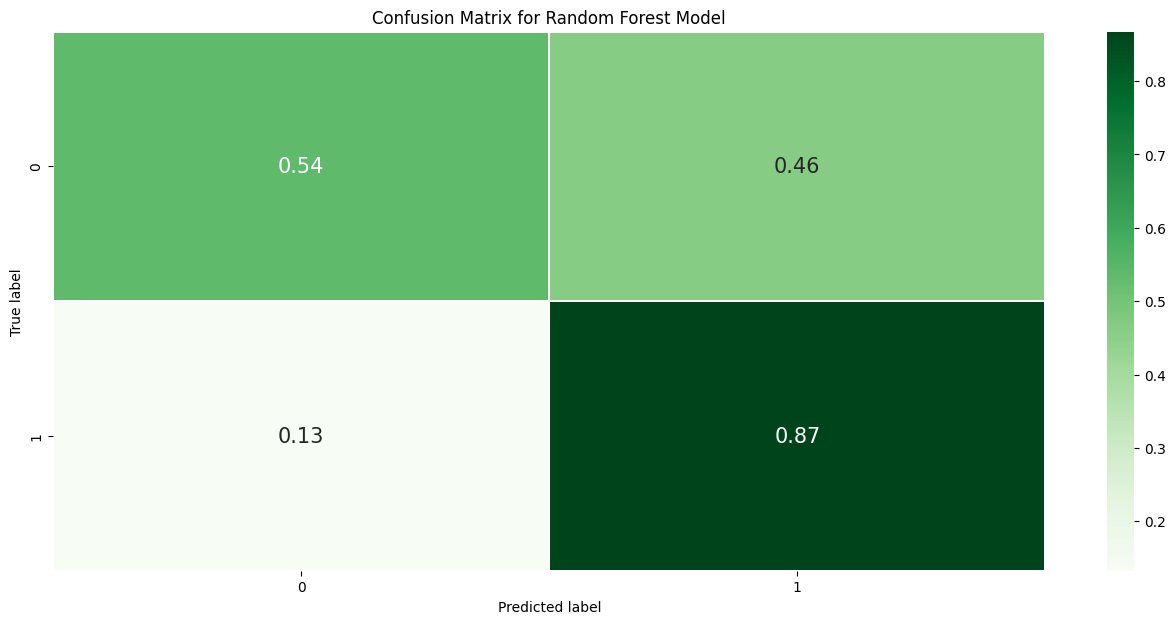

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       577
           1       0.72      0.87      0.79       799

    accuracy                           0.73      1376
   macro avg       0.73      0.70      0.71      1376
weighted avg       0.73      0.73      0.72      1376



array([9.00585359e-02, 7.90704233e-02, 4.53673380e-02, 9.57912604e-02,
       8.45458268e-02, 3.15248352e-02, 3.33691712e-02, 1.25092187e-01,
       1.22965027e-01, 1.40657740e-01, 7.83523662e-03, 1.45940654e-03,
       1.97550689e-03, 6.49770194e-03, 1.34777601e-02, 1.05140585e-02,
       9.75926738e-03, 8.94126409e-03, 3.55396020e-03, 2.97910627e-04,
       1.80287031e-04, 5.26229498e-04, 0.00000000e+00, 1.06245765e-03,
       2.65546277e-04, 2.32400549e-04, 6.54736806e-04, 1.29608328e-04,
       4.66920520e-05, 5.17972972e-04, 5.97694862e-05, 4.43640384e-05,
       4.07215332e-04, 6.29480835e-04, 4.32463638e-04, 0.00000000e+00,
       9.32568626e-03, 2.09191514e-04, 3.98412454e-05, 1.84043947e-03,
       2.01702709e-03, 2.46668252e-04, 3.38105538e-03, 7.33470030e-03,
       4.93714470e-05, 6.02030444e-05, 1.16087456e-04, 1.77897828e-04,
       2.81387770e-04, 6.03555601e-04, 1.51448155e-03, 1.06873194e-04,
       2.43268215e-04, 2.31306352e-04, 4.02993955e-04, 2.91410210e-04,
      

The feature importance for duration_create_to_expire is : 0.09005853594794423
The feature importance for value_in_eth is : 0.07907042326077614
The feature importance for value_in_token is : 0.04536733802852501
The feature importance for value_in_usdt is : 0.0957912604400586
The feature importance for value_in_usdt_now is : 0.08454582682072388
The feature importance for project_length_code is : 0.03152483520539523
The feature importance for experience_level_code is : 0.03336917123193443
The feature importance for description_length is : 0.1250921867698183
The feature importance for duration_create_to_new_bounty is : 0.12296502667510938
The feature importance for token_value_in_usdt is : 0.1406577395460418
The feature importance for bounty_type_Bug is : 0.007835236622745665
The feature importance for bounty_type_Code Review is : 0.00145940653665447
The feature importance for bounty_type_Design is : 0.001975506894445983
The feature importance for bounty_type_Documentation is : 0.006497701

,Feature,Feature Importance
9,token_value_in_usdt,0.140658
7,description_length,0.125092
8,duration_create_to_new_bounty,0.122965
3,value_in_usdt,0.095791
0,duration_create_to_expire,0.090059
4,value_in_usdt_now,0.084546
1,value_in_eth,0.079070
2,value_in_token,0.045367
6,experience_level_code,0.033369
5,project_length_code,0.031525


In [ ]:
#Setting 2 - without boothstrap

# Split dataset into features and target
y = new_raw_data_set2['is_success']
X = new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(10)

RandomForestClassifier(criterion='entropy', max_depth=25)

0.8662790697674418

array([[443, 131],
       [ 53, 749]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

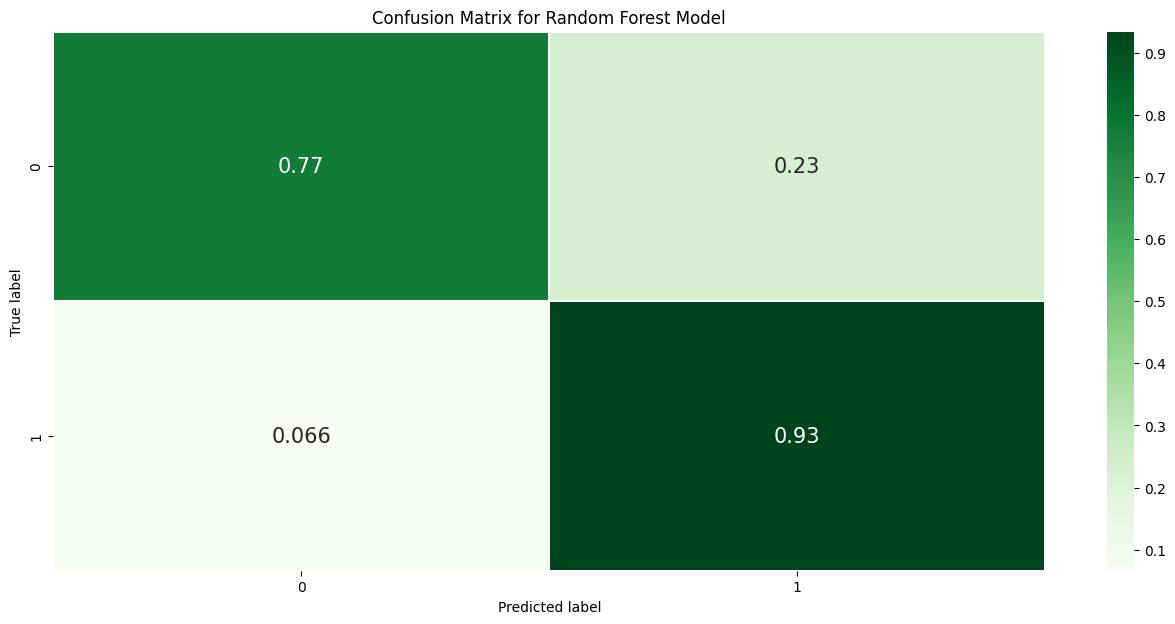

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       574
           1       0.85      0.93      0.89       802

    accuracy                           0.87      1376
   macro avg       0.87      0.85      0.86      1376
weighted avg       0.87      0.87      0.86      1376



array([8.80516094e-02, 7.74431108e-02, 4.67089748e-02, 9.91750407e-02,
       8.91902851e-02, 2.91844765e-02, 3.24825832e-02, 1.22935344e-01,
       1.26320695e-01, 1.33774480e-01, 7.43885953e-03, 1.36047630e-03,
       2.56903537e-03, 5.94582693e-03, 1.40515363e-02, 1.05325393e-02,
       9.36478275e-03, 9.18772338e-03, 2.08986643e-03, 0.00000000e+00,
       4.36758348e-04, 4.90399041e-05, 1.09039745e-04, 1.25351268e-03,
       2.71312221e-04, 3.12529342e-04, 2.04433198e-03, 1.92018227e-04,
       1.02270222e-04, 7.02334854e-04, 3.79799029e-05, 8.99095884e-05,
       7.95610148e-04, 4.24828227e-04, 3.54934819e-04, 8.27352355e-05,
       9.09560373e-03, 1.18702964e-04, 0.00000000e+00, 1.15896246e-03,
       2.51516189e-03, 3.78338425e-04, 2.40280393e-03, 8.57856481e-03,
       6.16902922e-05, 3.73765051e-05, 8.39685677e-05, 5.78876625e-05,
       0.00000000e+00, 2.97952977e-04, 2.29506653e-03, 0.00000000e+00,
       1.55726245e-04, 0.00000000e+00, 5.39561850e-04, 6.22722980e-04,
      

The feature importance for duration_create_to_expire is : 0.08805160941559301
The feature importance for value_in_eth is : 0.07744311083698074
The feature importance for value_in_token is : 0.04670897477190046
The feature importance for value_in_usdt is : 0.09917504073051259
The feature importance for value_in_usdt_now is : 0.08919028510444373
The feature importance for project_length_code is : 0.02918447647429796
The feature importance for experience_level_code is : 0.032482583211263495
The feature importance for description_length is : 0.12293534440038374
The feature importance for duration_create_to_new_bounty is : 0.12632069528978412
The feature importance for token_value_in_usdt is : 0.1337744802546047
The feature importance for bounty_type_Bug is : 0.007438859527428598
The feature importance for bounty_type_Code Review is : 0.0013604763045273593
The feature importance for bounty_type_Design is : 0.0025690353729195853
The feature importance for bounty_type_Documentation is : 0.005

,Feature,Feature Importance
9,token_value_in_usdt,0.133774
8,duration_create_to_new_bounty,0.126321
7,description_length,0.122935
3,value_in_usdt,0.099175
4,value_in_usdt_now,0.089190
0,duration_create_to_expire,0.088052
1,value_in_eth,0.077443
2,value_in_token,0.046709
6,experience_level_code,0.032483
5,project_length_code,0.029184


In [ ]:
#Setting 2 - with bootstrap

# Split dataset into features and target
y = bootstrapped_set2['is_success']
X = bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(10)

In [ ]:
#Point Biserial

In [ ]:
#https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1

from scipy.stats import pointbiserialr

for x in bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1):
    print (x)
    pointbiserialr(bootstrapped_set2['is_success'], bootstrapped_set2[x])

duration_create_to_expire


PointbiserialrResult(correlation=-0.11990490347083076, pvalue=3.780993854760727e-16)

value_in_eth


PointbiserialrResult(correlation=-0.035274361023034474, pvalue=0.016924164783396964)

value_in_token


PointbiserialrResult(correlation=-0.02473287628219492, pvalue=0.0940628482584795)

value_in_usdt


PointbiserialrResult(correlation=-0.03821417939281298, pvalue=0.009666403082876444)

value_in_usdt_now


PointbiserialrResult(correlation=-0.03523360951571318, pvalue=0.017051740771333722)

project_length_code


PointbiserialrResult(correlation=-0.03878662957935838, pvalue=0.008631103496813404)

experience_level_code


PointbiserialrResult(correlation=-0.09756270437115055, pvalue=3.604125903775364e-11)

description_length


PointbiserialrResult(correlation=-0.028744660399764484, pvalue=0.051650468750355706)

duration_create_to_new_bounty


PointbiserialrResult(correlation=0.006299226260343889, pvalue=0.6698320183232024)

token_value_in_usdt


PointbiserialrResult(correlation=-0.14669257845369557, pvalue=1.8055453209649214e-23)

bounty_type_Bug


PointbiserialrResult(correlation=-0.0317399940146094, pvalue=0.03164079415663226)

bounty_type_Code Review


PointbiserialrResult(correlation=-0.03174827257922508, pvalue=0.031596360571480374)

bounty_type_Design


PointbiserialrResult(correlation=-0.015802573971307153, pvalue=0.28475791600829814)

bounty_type_Documentation


PointbiserialrResult(correlation=0.06376718842861469, pvalue=1.5561042927617555e-05)

bounty_type_Feature


PointbiserialrResult(correlation=-0.03889000434866999, pvalue=0.008455084025203459)

bounty_type_Improvement


PointbiserialrResult(correlation=0.02153734759622751, pvalue=0.14485080225525154)

bounty_type_NA


PointbiserialrResult(correlation=0.05579324670496779, pvalue=0.00015720096978899927)

bounty_type_Other


PointbiserialrResult(correlation=-0.02014123866485256, pvalue=0.1727458153975459)

bounty_type_Security


PointbiserialrResult(correlation=-0.07160845876443664, pvalue=1.2149925066211908e-06)

token_name_0xBTC
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_AEUR


PointbiserialrResult(correlation=-0.024686920268489163, pvalue=0.09467570538920173)

token_name_AION


PointbiserialrResult(correlation=0.012501024674301805, pvalue=0.3974483470899343)

token_name_ALEX


PointbiserialrResult(correlation=0.01250102467430181, pvalue=0.3974483470899343)

token_name_ANT


PointbiserialrResult(correlation=0.014614786412068795, pvalue=0.3225258509379049)

token_name_AVO


PointbiserialrResult(correlation=0.0035884697246436675, pvalue=0.808088490980457)

token_name_BAND


PointbiserialrResult(correlation=0.021766775152955494, pvalue=0.14061694937927824)

token_name_BLZ


PointbiserialrResult(correlation=-0.062430935322255035, pvalue=2.3382089434654934e-05)

token_name_BNB


PointbiserialrResult(correlation=0.02165713593519654, pvalue=0.14262820832116935)

token_name_BNT


PointbiserialrResult(correlation=0.014563031495933125, pvalue=0.3242425730613028)

token_name_BORIS


PointbiserialrResult(correlation=-0.03023847887240448, pvalue=0.040637142194183164)

token_name_BRLN


PointbiserialrResult(correlation=0.012501024674301819, pvalue=0.3974483470899343)

token_name_BTC


PointbiserialrResult(correlation=-0.030238478872404568, pvalue=0.04063714219417439)

token_name_CBTX


PointbiserialrResult(correlation=-0.022427326565759464, pvalue=0.12895782950846146)

token_name_CHI


PointbiserialrResult(correlation=-0.04277767631855722, pvalue=0.003769790871928789)

token_name_CLN


PointbiserialrResult(correlation=0.010437276197448693, pvalue=0.4798866727932577)

token_name_COIN


PointbiserialrResult(correlation=0.012501024674301826, pvalue=0.3974483470899343)

token_name_DAI


PointbiserialrResult(correlation=0.1049512820168719, pvalue=1.052249270268135e-12)

token_name_DAT


PointbiserialrResult(correlation=-0.003502936271717413, pvalue=0.8125767298961386)

token_name_DATA


PointbiserialrResult(correlation=0.012501024674301826, pvalue=0.3974483470899343)

token_name_DIA


PointbiserialrResult(correlation=-0.05240891448568974, pvalue=0.0003854797320540969)

token_name_DOT


PointbiserialrResult(correlation=-0.08205653214053701, pvalue=2.643772116361903e-08)

token_name_ENG


PointbiserialrResult(correlation=0.030637849044327776, pvalue=0.038054778807489135)

token_name_ETC


PointbiserialrResult(correlation=-0.06993207307433115, pvalue=2.1447947733044547e-06)

token_name_ETH


PointbiserialrResult(correlation=-0.06333988933686688, pvalue=1.774041864709878e-05)

token_name_FIL


PointbiserialrResult(correlation=-0.03023847887240447, pvalue=0.040637142194183164)

token_name_G$


PointbiserialrResult(correlation=-0.017454384163648796, pvalue=0.23739580050802625)

token_name_GLM


PointbiserialrResult(correlation=-0.024686920268489218, pvalue=0.09467570538920173)

token_name_GLX


PointbiserialrResult(correlation=-0.017454384163648817, pvalue=0.23739580050796827)

token_name_GNO


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_HARBTY


PointbiserialrResult(correlation=-0.0008922227580582147, pvalue=0.9518436718216501)

token_name_HERC


PointbiserialrResult(correlation=-0.03570237640452467, pvalue=0.015633998536340725)

token_name_JAMM


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_KEEP


PointbiserialrResult(correlation=0.004358597665996148, pvalue=0.7679779618527732)

token_name_KIWI


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_KNC


PointbiserialrResult(correlation=-0.030238478872404478, pvalue=0.040637142194183164)

token_name_KSM


PointbiserialrResult(correlation=-0.049406199147030226, pvalue=0.0008193024734753755)

token_name_LEAP


PointbiserialrResult(correlation=-0.024686920268489215, pvalue=0.09467570538920173)

token_name_LIKE


PointbiserialrResult(correlation=-0.017454384163648803, pvalue=0.23739580050802625)

token_name_LINK


PointbiserialrResult(correlation=-0.04277767631855718, pvalue=0.003769790871928789)

token_name_LPT


PointbiserialrResult(correlation=-0.030846955430115768, pvalue=0.03675924397056083)

token_name_LRC


PointbiserialrResult(correlation=0.017681047725054324, pvalue=0.23135850839724542)

token_name_LUNA


PointbiserialrResult(correlation=-0.02468692026848917, pvalue=0.09467570538920173)

token_name_MANA


PointbiserialrResult(correlation=0.022789136453500555, pvalue=0.12289785958184749)

token_name_MATIC


PointbiserialrResult(correlation=-0.01745438416364882, pvalue=0.23739580050796827)

token_name_MESG


PointbiserialrResult(correlation=0.006166007256699503, pvalue=0.6764142768160308)

token_name_MYB


PointbiserialrResult(correlation=-0.03430332471359142, pvalue=0.0202025300404106)

token_name_NKN


PointbiserialrResult(correlation=-0.017454384163648806, pvalue=0.23739580050802625)

token_name_NTV


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_OCEAN


PointbiserialrResult(correlation=0.007554261354170731, pvalue=0.6091193626198588)

token_name_ONE


PointbiserialrResult(correlation=-0.017454384163648817, pvalue=0.23739580050796827)

token_name_OTHER


PointbiserialrResult(correlation=-0.03023847887240448, pvalue=0.040637142194183164)

token_name_PAN


PointbiserialrResult(correlation=-0.017454384163648817, pvalue=0.23739580050796827)

token_name_PBLC


PointbiserialrResult(correlation=-0.03023847887240449, pvalue=0.040637142194183164)

token_name_POLY


PointbiserialrResult(correlation=0.021766775152955546, pvalue=0.14061694937924576)

token_name_PROCN


PointbiserialrResult(correlation=0.01776755178755708, pvalue=0.22908342233213558)

token_name_RDN


PointbiserialrResult(correlation=-0.007010464049691131, pvalue=0.6351280271635402)

token_name_REN


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_RHOC


PointbiserialrResult(correlation=-0.039046232810317084, pvalue=0.008195155632372093)

token_name_RLC


PointbiserialrResult(correlation=0.03309627410846241, pvalue=0.02503942090390652)

token_name_RLY


PointbiserialrResult(correlation=0.024786337273313364, pvalue=0.09335391246954211)

token_name_SAI


PointbiserialrResult(correlation=0.07100622195422883, pvalue=1.4923511917521663e-06)

token_name_SC


PointbiserialrResult(correlation=0.012501024674301786, pvalue=0.3974483470899343)

token_name_SGR


PointbiserialrResult(correlation=-0.007839650482032553, pvalue=0.5956621430464475)

token_name_SHIP


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_SNT


PointbiserialrResult(correlation=0.020606490264381487, pvalue=0.16303542589060108)

token_name_SNX


PointbiserialrResult(correlation=0.0075542613541707175, pvalue=0.6091193626198588)

token_name_ST


PointbiserialrResult(correlation=0.012501024674301814, pvalue=0.3974483470899343)

token_name_STORJ


PointbiserialrResult(correlation=-0.012241600657191935, pvalue=0.40731631900620635)

token_name_SWAGG


PointbiserialrResult(correlation=0.02165713593519654, pvalue=0.14262820832116935)

token_name_SYSX


PointbiserialrResult(correlation=0.021657135935196564, pvalue=0.14262820832116935)

token_name_TRB


PointbiserialrResult(correlation=-0.036285791228446634, pvalue=0.0140150519302978)

token_name_TUSD


PointbiserialrResult(correlation=-0.012221721713565012, pvalue=0.4080784511272243)

token_name_USD


PointbiserialrResult(correlation=-0.024686920268489124, pvalue=0.09467570538920173)

token_name_USDC


PointbiserialrResult(correlation=-0.02473797202236603, pvalue=0.09399508912341796)

token_name_USDT


PointbiserialrResult(correlation=-0.05808420637726648, pvalue=8.324694218649443e-05)

token_name_WBTC


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_WYV


PointbiserialrResult(correlation=-0.03023847887240448, pvalue=0.040637142194183164)

token_name_XRT


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_ZIL


PointbiserialrResult(correlation=-0.01293994060320409, pvalue=0.3810846356957346)

token_name_ZRX


PointbiserialrResult(correlation=-0.028208331598360847, pvalue=0.056170422159357865)

token_name_aDAI


PointbiserialrResult(correlation=0.027965347572495514, pvalue=0.05832402658472573)

token_name_cUSD


PointbiserialrResult(correlation=0.012501024674301836, pvalue=0.3974483470899343)

token_name_wNXM


PointbiserialrResult(correlation=-0.02468692026848919, pvalue=0.09467570538920173)

project_type_contest


PointbiserialrResult(correlation=0.0893403656538296, pvalue=1.3673143240160296e-09)

project_type_cooperative


PointbiserialrResult(correlation=-0.09044253731003546, pvalue=8.551410084570431e-10)

project_type_traditional


PointbiserialrResult(correlation=-0.020226779756360988, pvalue=0.1709287560669483)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7dbb46d-be11-4d98-a8ae-f659e78e24c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>